In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score  
from sklearn.metrics import recall_score   
from sklearn.metrics import f1_score  
from sklearn import metrics
from yellowbrick.datasets import load_occupancy
from yellowbrick.model_selection import FeatureImportances

import os
from contextlib import redirect_stdout

import sys
from collections import Counter
import numpy as np
import numpy.random as rd
import pandas as pd
import scipy as sp
from scipy import stats as st
pd.options.display.max_rows = 999

from sklearn.covariance import GraphicalLasso
from sklearn.preprocessing import StandardScaler
#from sklearn.covariance import GraphLasso

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import font_manager
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
%matplotlib inline

from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from collections import Counter
from imblearn.datasets import fetch_datasets
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids

d:\users\izumu\documents\datascience1\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [19]:
# 8.6:1
ecoli = fetch_datasets()['ecoli']
# ecoli.data.shape
X_ecoli = ecoli.data
y_ecoli = ecoli.target
print(sorted(Counter(y_ecoli).items()))

# 15:1
thyroid_sick = fetch_datasets()['thyroid_sick']
X_thyroid_sick = thyroid_sick.data
y_thyroid_sick = thyroid_sick.target
print(sorted(Counter(y_thyroid_sick).items()))

# 34:1
ozone_level = fetch_datasets()['ozone_level']
X_ozone_level = ozone_level.data
y_ozone_level = ozone_level.target
print(sorted(Counter(y_ozone_level).items()))

# 130:1
abalone_19 = fetch_datasets()['abalone_19']
X_abalone_19 = abalone_19.data
y_abalone_19 = abalone_19.target
print(sorted(Counter(y_abalone_19).items()))

[(-1, 301), (1, 35)]
[(-1, 3541), (1, 231)]
[(-1, 2463), (1, 73)]
[(-1, 4145), (1, 32)]


下準備

以下の関数は、アルゴリズムの特性を説明するために、
リサンプリング後のサンプル空間をプロットするために使用されます。

In [3]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [4]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

分類してみる

多次元だがx_0,x_1を取り出して２次元平面で表示

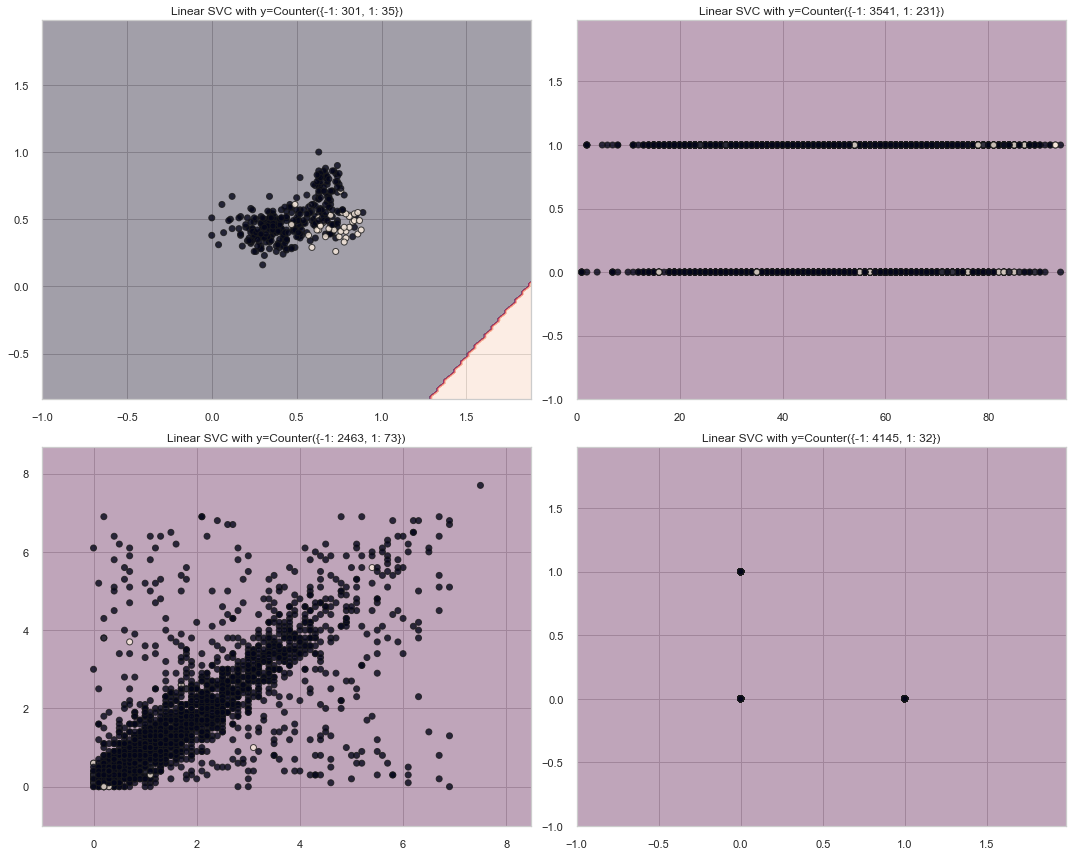

In [5]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

clf_ecoli = SVC(kernel='linear').fit(X_ecoli[:,:2], y_ecoli)
plot_decision_function(X_ecoli[:,:2],y_ecoli,clf_ecoli,ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y_ecoli)))

clf_thyroid_sick: object = SVC(kernel='linear').fit(X_thyroid_sick[:,:2], y_thyroid_sick)
plot_decision_function(X_thyroid_sick[:,:2],y_thyroid_sick,clf_thyroid_sick,ax2)
ax2.set_title('Linear SVC with y={}'.format(Counter(y_thyroid_sick)))

clf_ozone_level = SVC(kernel='linear').fit(X_ozone_level[:,:2], y_ozone_level)
plot_decision_function(X_ozone_level[:,:2],y_ozone_level,clf_ozone_level,ax3)
ax3.set_title('Linear SVC with y={}'.format(Counter(y_ozone_level)))

clf_abalone_19 = SVC(kernel='linear').fit(X_abalone_19[:,:2], y_abalone_19)
plot_decision_function(X_abalone_19[:,:2],y_abalone_19,clf_abalone_19,ax4)
ax4.set_title('Linear SVC with y={}'.format(Counter(y_abalone_19)))

fig.tight_layout()

精度

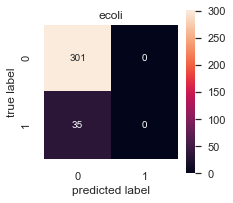

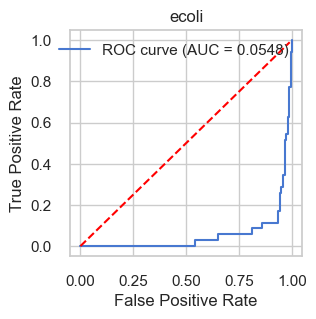

d:\users\izumu\documents\datascience1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
scores = {}

clf_ecoli = SVC(kernel='linear',probability=True).fit(X_ecoli, y_ecoli)
cmx_data = confusion_matrix(y_ecoli, clf_ecoli.predict(X_ecoli))
df_cmx = pd.DataFrame(cmx_data)
plt.figure(figsize=(3,3))
sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
plt.title("ecoli")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_ecoli, clf_ecoli.predict_proba(X_ecoli)[:,0], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(3,3), dpi=100)
plt.plot(fpr, tpr, label='ROC curve (AUC = %.4f)'%auc)
x = np.arange(0, 1, 0.01)
plt.plot(x, x, c = 'red', linestyle = '--')
plt.legend()
plt.title("ecoli")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

scores[("ecoli",'accuracy')] = accuracy_score(y_ecoli, clf_ecoli.predict(X_ecoli))
scores[("ecoli","recall")] = recall_score(y_ecoli, clf_ecoli.predict(X_ecoli), pos_label=1)
scores[("ecoli","precision")] = precision_score(y_ecoli, clf_ecoli.predict(X_ecoli), pos_label=1)
scores[("ecoli","f1_score")] = f1_score(y_ecoli, clf_ecoli.predict(X_ecoli), pos_label=1)

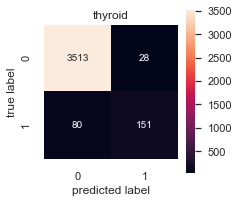

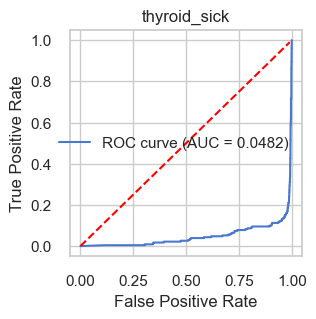

In [7]:
clf_thyroid_sick = SVC(kernel='linear', probability=True).fit(X_thyroid_sick, y_thyroid_sick)
cmx_data = confusion_matrix(y_thyroid_sick, clf_thyroid_sick.predict(X_thyroid_sick))
df_cmx = pd.DataFrame(cmx_data)
plt.figure(figsize=(3,3))
sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
plt.title("thyroid")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_thyroid_sick, clf_thyroid_sick.predict_proba(X_thyroid_sick)[:,0], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(3,3), dpi=100)
plt.plot(fpr, tpr, label='ROC curve (AUC = %.4f)'%auc)
x = np.arange(0, 1, 0.01)
plt.plot(x, x, c = 'red', linestyle = '--')
plt.legend()
plt.title("thyroid_sick")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

scores[("thyroid",'accuracy')] = accuracy_score(y_thyroid_sick, clf_thyroid_sick.predict(X_thyroid_sick))
scores[("thyroid","recall")] = recall_score(y_thyroid_sick, clf_thyroid_sick.predict(X_thyroid_sick), pos_label=1)
scores[("thyroid","precision")] = precision_score(y_thyroid_sick, clf_thyroid_sick.predict(X_thyroid_sick), pos_label=1)
scores[("thyroid","f1_score")] = f1_score(y_thyroid_sick, clf_thyroid_sick.predict(X_thyroid_sick), pos_label=1)

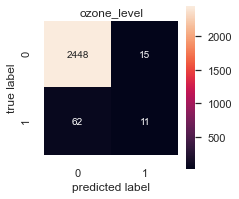

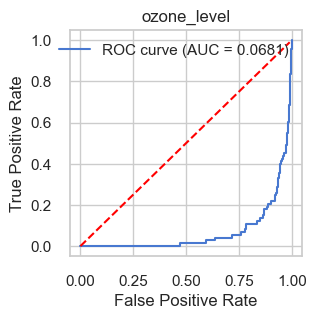

In [8]:
clf_ozone_level = SVC(kernel='linear',probability=True).fit(X_ozone_level, y_ozone_level)
cmx_data = confusion_matrix(y_ozone_level, clf_ozone_level.predict(X_ozone_level))
df_cmx = pd.DataFrame(cmx_data)
plt.figure(figsize=(3,3))
sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
plt.title("ozone_level")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_ozone_level, clf_ozone_level.predict_proba(X_ozone_level)[:,0], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(3,3), dpi=100)
plt.plot(fpr, tpr, label='ROC curve (AUC = %.4f)'%auc)
x = np.arange(0, 1, 0.01)
plt.plot(x, x, c = 'red', linestyle = '--')
plt.legend()
plt.title("ozone_level")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

scores[("ozone_level",'accuracy')] = accuracy_score(y_ozone_level, clf_ozone_level.predict(X_ozone_level))
scores[("ozone_level","recall")] = recall_score(y_ozone_level, clf_ozone_level.predict(X_ozone_level), pos_label=1)
scores[("ozone_level","precision")] = precision_score(y_ozone_level, clf_ozone_level.predict(X_ozone_level), pos_label=1)
scores[("ozone_level","f1_score")] = f1_score(y_ozone_level, clf_ozone_level.predict(X_ozone_level), pos_label=1)

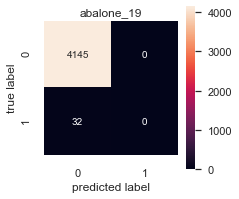

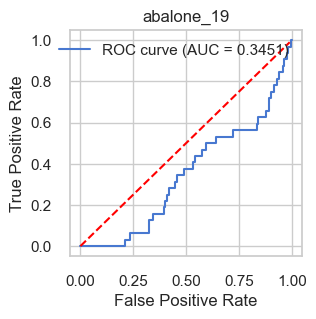

d:\users\izumu\documents\datascience1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
clf_abalone_19 = SVC(kernel='linear',probability=True).fit(X_abalone_19, y_abalone_19)
cmx_data = confusion_matrix(y_abalone_19, clf_abalone_19.predict(X_abalone_19))
df_cmx = pd.DataFrame(cmx_data)
plt.figure(figsize=(3,3))
sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
plt.title("abalone_19")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_abalone_19, clf_abalone_19.predict_proba(X_abalone_19)[:,0], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(3,3), dpi=100)
plt.plot(fpr, tpr, label='ROC curve (AUC = %.4f)'%auc)
x = np.arange(0, 1, 0.01)
plt.plot(x, x, c = 'red', linestyle = '--')
plt.legend()
plt.title("abalone_19")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

scores[("abalone_19",'accuracy')] = accuracy_score(y_abalone_19, clf_abalone_19.predict(X_abalone_19))
scores[("abalone_19","recall")] = recall_score(y_abalone_19, clf_abalone_19.predict(X_abalone_19), pos_label=1)
scores[("abalone_19","precision")] = precision_score(y_abalone_19, clf_abalone_19.predict(X_abalone_19), pos_label=1)
scores[("abalone_19","f1_score")] = f1_score(y_abalone_19, clf_abalone_19.predict(X_abalone_19), pos_label=1)

精度(Accuracy)：真陽性と真陰性の割合の大きさ

適合率(Precision)：正と予測したもののうち実際に正だった割合

再現率(Recall)：正だったもののうち正と予測されていたものの割合

F値：再現率と適合率の調和平均

In [10]:
print("Metrics:")
print(pd.Series(scores).unstack())

Metrics:
             accuracy  f1_score  precision    recall
abalone_19   0.992339  0.000000   0.000000  0.000000
ecoli        0.895833  0.000000   0.000000  0.000000
ozone_level  0.969637  0.222222   0.423077  0.150685
thyroid      0.971368  0.736585   0.843575  0.653680


オーバーサンプリング：トレーニングデータの少ないクラスを疑似的に増やす

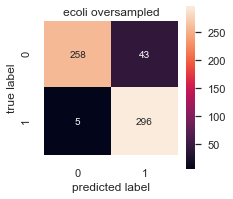

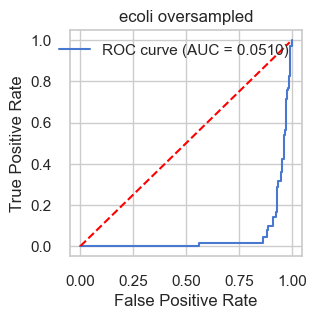

In [20]:
scores_oversampled = {}

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_ecoli,y_ecoli)

clf_resampled = SVC(kernel='linear',probability=True).fit(X_resampled, y_resampled)
cmx_data = confusion_matrix(y_resampled, clf_resampled.predict(X_resampled))
df_cmx = pd.DataFrame(cmx_data)
plt.figure(figsize=(3,3))
sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
plt.title("ecoli oversampled")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_resampled, clf_resampled.predict_proba(X_resampled)[:,0], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(3,3), dpi=100)
plt.plot(fpr, tpr, label='ROC curve (AUC = %.4f)'%auc)
x = np.arange(0, 1, 0.01)
plt.plot(x, x, c = 'red', linestyle = '--')
plt.legend()
plt.title("ecoli oversampled")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

scores_oversampled[("ecoli",'accuracy')] = accuracy_score(y_resampled, clf_resampled.predict(X_resampled))
scores_oversampled[("ecoli","recall")] = recall_score(y_resampled, clf_resampled.predict(X_resampled), pos_label=1)
scores_oversampled[("ecoli","precision")] = precision_score(y_resampled, clf_resampled.predict(X_resampled), pos_label=1)
scores_oversampled[("ecoli","f1_score")] = f1_score(y_resampled, clf_resampled.predict(X_resampled), pos_label=1)

Text(0.5, 1.0, 'Linear SVC with y=Counter({-1: 301, 1: 301})')

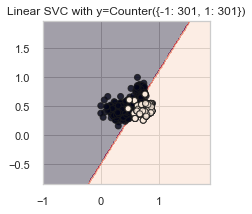

In [24]:
fig, ax1= plt.subplots(1, 1, figsize=(3, 3))

clf_resampled = SVC(kernel='linear').fit(X_resampled[:,:2], y_resampled)
plot_decision_function(X_resampled[:,:2],y_resampled,clf_resampled,ax1)
ax1.set_title('Linear SVC with y={}'.format(Counter(y_resampled)))

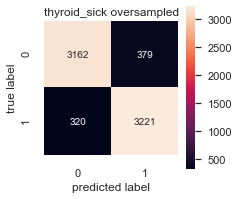

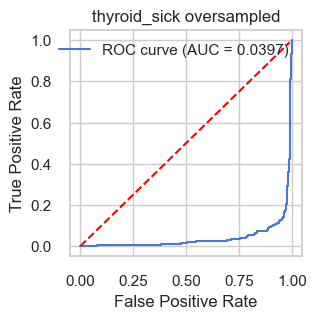

In [17]:
X_resampled, y_resampled = ros.fit_resample(X_thyroid_sick,y_thyroid_sick)

clf_resampled = SVC(kernel='linear',probability=True).fit(X_resampled, y_resampled)
cmx_data = confusion_matrix(y_resampled, clf_resampled.predict(X_resampled))
df_cmx = pd.DataFrame(cmx_data)
plt.figure(figsize=(3,3))
sns.heatmap(df_cmx, fmt='d', annot=True, square=True)
plt.title("thyroid_sick oversampled")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_resampled, clf_resampled.predict_proba(X_resampled)[:,0], pos_label=1)
auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(3,3), dpi=100)
plt.plot(fpr, tpr, label='ROC curve (AUC = %.4f)'%auc)
x = np.arange(0, 1, 0.01)
plt.plot(x, x, c = 'red', linestyle = '--')
plt.legend()
plt.title("thyroid_sick oversampled")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

scores_oversampled[("thyroid_sick",'accuracy')] = accuracy_score(y_resampled, clf_resampled.predict(X_resampled))
scores_oversampled[("thyroid_sick","recall")] = recall_score(y_resampled, clf_resampled.predict(X_resampled), pos_label=1)
scores_oversampled[("thyroid_sick","precision")] = precision_score(y_resampled, clf_resampled.predict(X_resampled), pos_label=1)
scores_oversampled[("thyroid_sick","f1_score")] = f1_score(y_resampled, clf_resampled.predict(X_resampled), pos_label=1)

In [18]:
print("Previous Metrics:")
print(pd.Series(scores).unstack())

print("Oversampled Metrics")
print(pd.Series(scores_oversampled).unstack())


Previous Metrics:
             accuracy  f1_score  precision    recall
abalone_19   0.992339  0.000000   0.000000  0.000000
ecoli        0.895833  0.000000   0.000000  0.000000
ozone_level  0.969637  0.222222   0.423077  0.150685
thyroid      0.971368  0.736585   0.843575  0.653680
Oversampled Metrics
              accuracy  f1_score  precision    recall
ecoli         0.920266  0.925000   0.873156  0.983389
thyroid_sick  0.901299  0.902115   0.894722  0.909630
